This notebook deals with the single query benchmarks comparing different data structures with periodic boundary conditions. Different data structures include :

* Brute Force implemented in MDAnalysis (see [here](https://github.com/MDAnalysis/mdanalysis))
* CellList implemented in FATSLiM (see [here](http://fatslim.github.io/))
* CellList implemented in CellGrid (see [here](https://github.com/MDAnalysis/cellgrid))
* Non Periodic KDTree implemented in BioPython (see [here](http://biopython.org/DIST/docs/api/Bio.KDTree-module.html))
* Non Periodic cKDTree implementation in Scipy (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html))
* Non Periodic Octree implemented in PCL (see [here](https://github.com/strawlab/python-pcl))

Previous benchmarks compared the performance of these methods but was limited by ability of various data structures to deal with the periodic boundary conditions. Therefore, a fixed single query at the centre of the box was chosen for single query distance evaluations. It was found that Scipy ckdtree is faster than Biopython's KDTree implementation for non-periodic boundary conditions. Other interesting feature was query and build time for non-periodic octree was the fastest followed by cell-list data structure implemented in FATSLiM. More details can be found [here](http://localhost:8888/notebooks/SingleQuery_NoPBC.ipynb) and [here](http://localhost:8888/notebooks/OctreeComparison.ipynb).

The goal of this notebook is to benchmark all the above mentioned methods such that they handle periodic boundary conditions as well. Periodic Boundary conditions are applied such that any particle going away from any of the face results in a similar particle approaching the opposite face in a box. 

While KDTree implementation in MDAnalysis as well as Brute force and Cell-list implementations are periodic aware, others like Octree and various implemenations of KDTree are not PBC aware. To get around this drawback, an intuitive fix is to increase the box size and introduce relevant images of particles (which might have been present within the cutoff distance from the box face). These particles can then be sent to any other PBC-unaware data structures for evaluations.  

Lets begin by defining the helper functions which takes in a set of coordinates, and returns the augmented coordinates i.e. original coordinates and image particles along with the mapping of image particles. These augmented particles can be used for distance operations. The returned pairs can then be postprocessed using the mapping to return the original set of coordinates.

In [44]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import defaultdict
def augment(points, cutoff, box):
    """
    Augments the cordinates and returns the coordinates in 
    the extended box, such that all the atoms in the box 
    are PBC aware
    
    Parameters
    ----------
    points : coordinates of dimension (N, 3)
    cutoff : cutoff radius 
    box : PBC aware box
    
    Returns
    -------
    augmented_coords : similar to points but added coordinates 
    mapid : hash map with the original to artificial mapping
    """
    a, b, c = box[:3]
    dm = np.array([[a, 0, 0], [0, b, 0], [0, 0, c]], dtype=np.float32)
    rm = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
    
    augmented_coords = points.copy() ## So as to not change the original coordinates
    mapid = defaultdict(list) # hash maps
    for idx, coords in enumerate(points):
        images = list()
        distances = np.dot(rm, coords)
        displacements = list(dm[np.where(distances < cutoff)[0]])
        distances = np.einsum('ij,ij->i', rm,dm - coords)
        displacements.extend(list(-dm[np.where(distances < cutoff)[0]]))
        n_displacements = len(displacements)
        if n_displacements > 1:
            for start in range(n_displacements - 1, -1, -1):
                for i in range(start+1, len(displacements)):
                    displacements.append(displacements[start]+displacements[i])
        images.extend([coords + d for d in displacements])
        updated_N = len(augmented_coords)
        if len(images) > 0 :
            augmented_coords = np.append(augmented_coords, [images[i] for i in range(len(images))], axis = 0)
            for newidx in range(len(images)):
                mapid[updated_N + newidx].append(idx)
    return augmented_coords, mapid

In [4]:
def inverse_augment(pairs, mapid, N):
    """
    Returns the set of unique pairs
    
    pairs is a list of pairs which needs to be replaced
    
    Parameters
    ----------
    pairs : tuple of indices
    mapid : hash map returned from augment 
    N : Number of points in original indices
    
    Returns
    -------
    numpy array of unique bonds
    """

    for idx, val in enumerate(pairs[0]):
        if val >= N:
            pairs[0][idx] = mapid[val][0]
    if pairs.shape[1] == 0:
        return pairs
    else:
        return np.unique(pairs, axis = 0) 

Inorder to check the correct implementation to return the augment coordinates. Lets begin by checking it against the brute force for a single query

In [5]:
from MDAnalysis.lib.distances import distance_array
def bf_select(query, points, maxdist, box = None):
    bonds = []
    if query.shape[0] == 3:
        query = query[None,:]
    for i,coordinate in enumerate(query):
        dist = distance_array(coordinate[None, :], points,box=box)[0]
        idx = np.where((dist <= maxdist))[0]
        bonds.append(idx)
    return np.array(bonds)

In [6]:
def aug_select(function, points, maxdist, box):
    augment_coords, mapid = augment(points, maxdist, box)
    art_bonds = function(augment_coords, maxdist)
    bonds = inverse_augment(art_bonds, mapid, len(points))
    return bonds

In [7]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [8]:
#Initialize
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 10.
NPOINTS = 1000
points = get_coords(BOX, NPOINTS)

In [64]:
query = np.array([1.,1.,1.], dtype = np.float32)

In [65]:
bf_n = bf_select(query, points, CUTOFF, BOX)

In [66]:
bf_n

array([[339, 524, 698, 926]])

Lets test the augment function output using similar function but not invoking any PBC while doing so.

In [71]:
aug_points, mapping = augment(points, CUTOFF, BOX)

In [72]:
all_bonds = bf_select(query, aug_points, CUTOFF)
all_bonds

array([[1241, 1381, 1494, 1638]])

In [73]:
bonds = inverse_augment(all_bonds, mapping, len(points))

In [74]:
np.sort(bonds)

array([[339, 524, 698, 926]])

In [75]:
bonds.shape, bf_n.shape

((1, 4), (1, 4))

In [39]:
np.testing.assert_array_equal(bf_n, np.sort(bonds))

The augment function is operational without passing the box as an argument. Lets move on to the definitions of the other functions, such that the augment function works in a similar fashion. Inputs and outputs are also kept consistent for all the functions. Furthermore, lets seperate build and query time as well to check individual time difference.

# FATSLiM

This is already PBC aware, so no need for augment coordinates. The function returns the coordinates of the 

In [9]:
from core_ns import FastNS
def ns_build(box, coords, cutoff):
    triclinic_box = np.array([[box[0], 0, 0],[0, box[1], 0],[0,0,box[2]]], dtype=np.float32)
    searcher = FastNS(triclinic_box)
    searcher.set_cutoff(cutoff)
    searcher.set_coords(coords)
    searcher.prepare()
    return searcher
def ns_query(struct, coords, query):
    results, sqdist, index = struct.search(np.array([query,]))
    return np.array(index)

# Cellgrid

In [10]:
import cellgrid
from cellgrid.cgmath import (
    inter_distance_array_withpbc,
    inter_index_array,
)
def cg_build(box, coords, cellsize):
    
    cg1 = cellgrid.CellGrid(box[:3], cellsize, coords)
    return cg1

def cg_query(struct,pos,cutoff):
    
    cell = (pos/struct._cell_size).astype(int)
    
    ##Array Initialization
    n_tot = 0
    #print(struct[cell].all_neighbours)
    for other_cell in itertools.chain(struct[cell].all_neighbours,[cell]):
        n_tot += len(struct[other_cell]) 
    distances = np.zeros(n_tot, dtype=np.float32)
    pair_indices = np.zeros((n_tot, 2), dtype=np.int)
    
    ##Distance Evaluations
    p = 0 # pointer to array
    indices = []
    for item in itertools.chain(struct[cell].all_neighbours,[cell]):
        other_cell = struct[item]
        length = len(other_cell)
        inter_distance_array_withpbc(pos[np.newaxis,:], other_cell.coordinates, struct._box, distances[p:])
        indices += [i for i in itertools.chain(other_cell.indices)]
        p +=  len(other_cell)
    
    mask = np.where((distances <= cutoff) & (distances > 0))
    #return None if struct.coordinates[np.array(indices)[mask]].shape[0] == 0 else struct.coordinates[np.array(indices)[mask]]
    return np.reshape(np.array(indices)[mask], (1 , np.array(indices)[mask].shape[0] ))

# BioPython

In [11]:
from Bio.KDTree import KDTree
def bp_build(box, coords):
    kdtree = KDTree(dim=3)
    kdtree.set_coords(coords)
    return kdtree
def bp_query(struct, coords, query, cutoff):
    struct.search(query,cutoff)
    return struct.get_indices()
def augbp_build(box, coords, cutoff):
    augment_coords, mapid = augment(points, cutoff, box)
    bp = bp_build(box, augment_coords)
    return bp, augment_coords, mapid
def augbp_query(struct, augment_coords, query, cutoff, mapid):
    art_indices = bp_query(struct, augment_coords, query, cutoff)
    art_indices = np.reshape(art_indices, (1, len(art_indices)))
    indices = inverse_augment(art_indices, mapid, min(mapid.keys()))
    return indices

# Scipy

In [12]:
from scipy import spatial
def scipy_build(box, coords):
    return spatial.cKDTree(coords)
def scipy_query(struct, coords, query, cutoff):
    return struct.query_ball_point(query,cutoff)
def augscipy_build(box, coords, cutoff):
    augment_coords, mapid = augment(points, cutoff, box)
    skd = scipy_build(box, augment_coords)
    return skd, augment_coords, mapid
def augscipy_query(struct, augment_coords, query, cutoff, mapid):
    art_indices = scipy_query(struct, augment_coords, query, cutoff)
    art_indices = np.reshape(art_indices, (1, len(art_indices)))
    indices = inverse_augment(art_indices, mapid, min(mapid.keys()))
    return indices

# PKDTree

In [13]:
from MDAnalysis.lib.pkdtree import PeriodicKDTree
def pkdt_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def pkdt_query(struct, coords, query, cutoff):
    struct.search(query,cutoff)
    return np.reshape(np.array(struct.get_indices()), (1, np.array(struct.get_indices()).shape[0])) 

# Octree

In [14]:
import pcl
def oct_build(box, coords):
    cloud = pcl.PointCloud(coords)
    resolution = 0.1*BOX[0]
    octree = cloud.make_octreeSearch(resolution)
    octree.add_points_from_input_cloud()
    return octree
def oct_query(struct, coords, query, cutoff):
    [ind, sqdist] = struct.radius_search (query, cutoff)
    return np.array(ind)
def augoct_build(box, coords, cutoff):
    augment_coords, mapid = augment(points, cutoff, box)
    octree = oct_build(box, augment_coords)
    return octree, augment_coords, mapid
def augoct_query(struct, augment_coords, query, cutoff, mapid):
    art_indices = oct_query(struct, augment_coords, query, cutoff)
    art_indices = np.reshape(art_indices, (1, len(art_indices)))
    indices = inverse_augment(art_indices, mapid, min(mapid.keys()))
    return indices

# Check

Check for the neighbours for a simple case.

In [15]:
#initialize
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 10.
NPOINTS = 10
points = get_coords(BOX, NPOINTS)
query = np.array([1.,1.,1.], dtype = np.float32)

### FATSLiM

In [16]:
ns = ns_build(BOX, points, CUTOFF)
ns_b = ns_query(ns, points, query)

In [17]:
np.sort(ns_b)

array([], shape=(1, 0), dtype=int64)

In [18]:
ns_b.shape

(1, 0)

### CellGrid

In [19]:
cg = cg_build(BOX, points, CUTOFF)
cg_b = cg_query(cg , query ,CUTOFF)

In [20]:
cg_b

array([], shape=(1, 0), dtype=int64)

In [21]:
cg_b.shape

(1, 0)

### BioPython KDTree

In [22]:
bp, augment_coords, mapid = augbp_build(BOX, points, CUTOFF)

In [23]:
bp_b = augbp_query(bp, augment_coords, query, CUTOFF, mapid)

In [24]:
bp_b

array([], shape=(1, 0), dtype=float64)

In [25]:
bp_b.shape

(1, 0)

### Scipy KDTree

In [26]:
sckd, augment_coords, mapid = augscipy_build(BOX, points, CUTOFF)

In [27]:
sckd_b = augscipy_query(sckd, augment_coords, query, CUTOFF, mapid)

In [28]:
sckd_b

array([], shape=(1, 0), dtype=float64)

In [29]:
sckd_b.shape

(1, 0)

### Periodic KDtree

In [30]:
pkdt = pkdt_build(BOX, points)
pkdt_b = pkdt_query(pkdt, points, query, CUTOFF)

In [31]:
pkdt_b

array([], shape=(1, 0), dtype=float64)

In [32]:
pkdt_b.shape

(1, 0)

### Octree

In [33]:
octree, augment_coords, mapid = augoct_build(BOX, points, CUTOFF)
oct_b = augoct_query(octree, augment_coords, query, CUTOFF, mapid)

In [34]:
oct_b

array([], shape=(1, 0), dtype=int32)

In [35]:
oct_b.shape

(1, 0)

## Testing

In [36]:
for (a,b) in itertools.combinations([ns_b, cg_b, bp_b, sckd_b, pkdt_b, oct_b],2):
    np.testing.assert_array_equal(np.sort(a, axis = 1), np.sort(b, axis = 1))

# Benchmarking

For comparison, lets choose one point inside the domain of the box and another near one of the faces. The parameters for benchmark are number of particles . Lets begin by the benchmarks of number of particles.

In [57]:
#initialize
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = np.logspace(2,5, num = 5, dtype = np.int)
#points = get_coords(BOX, NPOINTS)
query = np.array([1.,1.,1.], dtype = np.float32) ## Close to the one of the phases

In [58]:
from tqdm import tqdm_notebook

res_build = defaultdict(list)
res_query = defaultdict(list)
res_total = defaultdict(list)

for N in tqdm_notebook(np.unique(npoints)):
    points = get_coords(box, N)
    
    # FATSLiM
    #ns = ns_build(box, points, cutoff)
    #ns_b = ns_query(ns, points, query)
    ##build
    #bres = %timeit -q -o ns_build(box, points, cutoff)
    #res_build['ns'].append(bres.average)
    ##query
    #qres = %timeit -q -o ns_query(ns, points, query)
    #res_query['ns'].append(qres.average)
    ##Total
    #res_total['ns'].append(bres.average + qres.average)
    
    # CellGrid
    cg = cg_build(box, points, cutoff)
    cg_b = cg_query(cg , query ,cutoff)
    ## build
    bres = %timeit -q -o cg_build(box, points, cutoff)
    res_build['cg'].append(bres.average)
    ## querybres = %timeit -q -o cg_build(BOX, points, CUTOFF)
    qres = %timeit -q -o cg_query(cg, query, cutoff)
    res_query['cg'].append(qres.average)
    ## Total
    res_total['cg'].append(bres.average + qres.average)
    
    # Biopython
    bp, augment_coords, mapid = augbp_build(box, points, cutoff)
    bp_b = augbp_query(bp, augment_coords, query, cutoff, mapid)
    ## build
    bres = %timeit -q -o augbp_build(box, points, cutoff)
    res_build['bp'].append(bres.average)
    ##query
    qres = %timeit -q -o augbp_query(bp, augment_coords, query, cutoff, mapid)
    res_query['bp'].append(qres.average)
    ## Total
    res_total['bp'].append(bres.average + qres.average)
    
    # Scipy
    sckd, augment_coords, mapid = augscipy_build(box, points, cutoff)
    sckd_b = augscipy_query(sckd, augment_coords, query, cutoff, mapid)
    ## build
    bres = %timeit -q -o augscipy_build(box, points, cutoff)
    res_build['scipy'].append(bres.average)
    ##query
    qres = %timeit -q -o augscipy_query(sckd, augment_coords, query, cutoff, mapid)
    res_query['scipy'].append(qres.average)
    ## Total
    res_total['scipy'].append(bres.average + qres.average)
    
    # Periodic KDTree
    pkdt = pkdt_build(box, points)
    pkdt_b = pkdt_query(pkdt, points, query, cutoff)
    ## build
    bres = %timeit -q -o pkdt_build(box, points)
    res_build['pkdt'].append(bres.average)
    ##query
    qres = %timeit -q -o pkdt_query(pkdt, points, query, cutoff)
    res_query['pkdt'].append(qres.average)
    ## Total
    res_total['pkdt'].append(bres.average + qres.average)
    
    # Octree
    octree, augment_coords, mapid = augoct_build(box, points, cutoff)
    oct_b = augoct_query(octree, augment_coords, query, cutoff, mapid)
    ## build
    bres = %timeit -q -o augoct_build(BOX, points, CUTOFF)
    res_build['octree'].append(bres.average)
    ##query
    qres = %timeit -q -o augoct_query(octree, augment_coords, query, cutoff, mapid)
    res_query['octree'].append(qres.average)
    ##Total
    res_total['octree'].append(bres.average + qres.average)
    
    # Brute Force
    bf_n = bf_select(query, points, cutoff, box)
    res = %timeit -q -o bf_select(query, points, cutoff, BOX)
    #Total
    res_total['bf'].append(res.average)
    
    res_total['N'].append(N)
    
    #testing
    for (a,b) in itertools.combinations([ cg_b, bp_b, sckd_b, pkdt_b, oct_b, bf_n],2):
        np.testing.assert_array_equal(np.sort(a, axis = 1), np.sort(b, axis = 1))

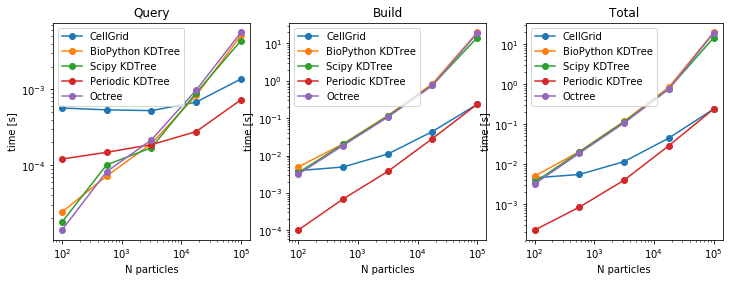

In [60]:
fig, axes = plt.subplots(ncols = 3, figsize = plt.figaspect(1/3))

ax = axes[0]
ax.plot(res_total['N'], res_query['cg'], 'o-', label='CellGrid')
ax.plot(res_total['N'], res_query['bp'], 'o-', label='BioPython KDTree')
ax.plot(res_total['N'], res_query['scipy'], 'o-', label='Scipy KDTree')
ax.plot(res_total['N'], res_query['pkdt'], 'o-', label='Periodic KDTree')
ax.plot(res_total['N'], res_query['octree'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(res_total['N'], res_build['cg'], 'o-', label='CellGrid')
ax.plot(res_total['N'], res_build['bp'], 'o-', label='BioPython KDTree')
ax.plot(res_total['N'], res_build['scipy'], 'o-', label='Scipy KDTree')
ax.plot(res_total['N'], res_build['pkdt'], 'o-', label='Periodic KDTree')
ax.plot(res_total['N'], res_build['octree'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[2]
ax.plot(res_total['N'], res_total['cg'], 'o-', label='CellGrid')
ax.plot(res_total['N'], res_total['bp'], 'o-', label='BioPython KDTree')
ax.plot(res_total['N'], res_total['scipy'], 'o-', label='Scipy KDTree')
ax.plot(res_total['N'], res_total['pkdt'], 'o-', label='Periodic KDTree')
ax.plot(res_total['N'], res_total['octree'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total')
ax.legend()

Lets check the timings for a query point inside the box such that PBC is not invoked.

In [61]:
#initialize
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = np.logspace(2,5, num = 5, dtype = np.int)
#points = get_coords(BOX, NPOINTS)
query = box[:3]/2 ## Close to the one of the phases

In [62]:
from tqdm import tqdm_notebook

res_build2 = defaultdict(list)
res_query2 = defaultdict(list)
res_total2 = defaultdict(list)

for N in tqdm_notebook(np.unique(npoints)):
    points = get_coords(box, N)
    
    # FATSLiM
    #ns = ns_build(box, points, cutoff)
    #ns_b = ns_query(ns, points, query)
    ##build
    #bres = %timeit -q -o ns_build(box, points, cutoff)
    #res_build['ns'].append(bres.average)
    ##query
    #qres = %timeit -q -o ns_query(ns, points, query)
    #res_query['ns'].append(qres.average)
    ##Total
    #res_total['ns'].append(bres.average + qres.average)
    
    # CellGrid
    cg = cg_build(box, points, cutoff)
    cg_b = cg_query(cg , query ,cutoff)
    ## build
    bres = %timeit -q -o cg_build(box, points, cutoff)
    res_build2['cg'].append(bres.average)
    ## querybres = %timeit -q -o cg_build(BOX, points, CUTOFF)
    qres = %timeit -q -o cg_query(cg, query, cutoff)
    res_query2['cg'].append(qres.average)
    ## Total
    res_total2['cg'].append(bres.average + qres.average)
    
    # Biopython
    bp, augment_coords, mapid = augbp_build(box, points, cutoff)
    bp_b = augbp_query(bp, augment_coords, query, cutoff, mapid)
    ## build
    bres = %timeit -q -o augbp_build(box, points, cutoff)
    res_build2['bp'].append(bres.average)
    ##query
    qres = %timeit -q -o augbp_query(bp, augment_coords, query, cutoff, mapid)
    res_query2['bp'].append(qres.average)
    ## Total
    res_total2['bp'].append(bres.average + qres.average)
    
    # Scipy
    sckd, augment_coords, mapid = augscipy_build(box, points, cutoff)
    sckd_b = augscipy_query(sckd, augment_coords, query, cutoff, mapid)
    ## build
    bres = %timeit -q -o augscipy_build(box, points, cutoff)
    res_build2['scipy'].append(bres.average)
    ##query
    qres = %timeit -q -o augscipy_query(sckd, augment_coords, query, cutoff, mapid)
    res_query2['scipy'].append(qres.average)
    ## Total
    res_total2['scipy'].append(bres.average + qres.average)
    
    # Periodic KDTree
    pkdt = pkdt_build(box, points)
    pkdt_b = pkdt_query(pkdt, points, query, cutoff)
    ## build
    bres = %timeit -q -o pkdt_build(box, points)
    res_build2['pkdt'].append(bres.average)
    ##query
    qres = %timeit -q -o pkdt_query(pkdt, points, query, cutoff)
    res_query2['pkdt'].append(qres.average)
    ## Total
    res_total2['pkdt'].append(bres.average + qres.average)
    
    # Octree
    octree, augment_coords, mapid = augoct_build(box, points, cutoff)
    oct_b = augoct_query(octree, augment_coords, query, cutoff, mapid)
    ## build
    bres = %timeit -q -o augoct_build(BOX, points, CUTOFF)
    res_build2['octree'].append(bres.average)
    ##query
    qres = %timeit -q -o augoct_query(octree, augment_coords, query, cutoff, mapid)
    res_query2['octree'].append(qres.average)
    ##Total
    res_total2['octree'].append(bres.average + qres.average)
    
    # Brute Force
    bf_n = bf_select(query, points, cutoff, box)
    res = %timeit -q -o bf_select(query, points, cutoff, BOX)
    #Total
    res_total2['bf'].append(res.average)
    
    res_total2['N'].append(N)
    
    #testing
    for (a,b) in itertools.combinations([ cg_b, bp_b, sckd_b, pkdt_b, oct_b, bf_n],2):
        np.testing.assert_array_equal(np.sort(a, axis = 1), np.sort(b, axis = 1))

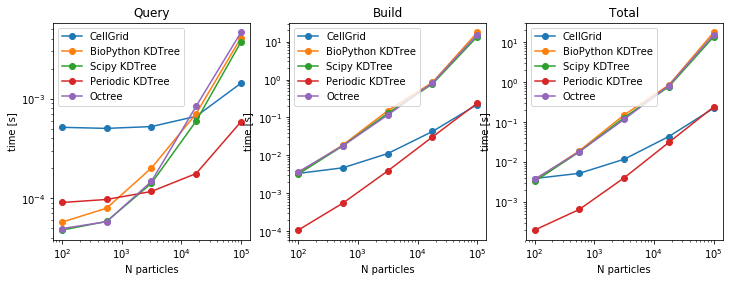

In [64]:
fig, axes = plt.subplots(ncols = 3, figsize = plt.figaspect(1/3))

ax = axes[0]
ax.plot(res_total2['N'], res_query2['cg'], 'o-', label='CellGrid')
ax.plot(res_total2['N'], res_query2['bp'], 'o-', label='BioPython KDTree')
ax.plot(res_total2['N'], res_query2['scipy'], 'o-', label='Scipy KDTree')
ax.plot(res_total2['N'], res_query2['pkdt'], 'o-', label='Periodic KDTree')
ax.plot(res_total2['N'], res_query2['octree'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(res_total2['N'], res_build2['cg'], 'o-', label='CellGrid')
ax.plot(res_total2['N'], res_build2['bp'], 'o-', label='BioPython KDTree')
ax.plot(res_total2['N'], res_build2['scipy'], 'o-', label='Scipy KDTree')
ax.plot(res_total2['N'], res_build2['pkdt'], 'o-', label='Periodic KDTree')
ax.plot(res_total2['N'], res_build2['octree'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[2]
ax.plot(res_total2['N'], res_total2['cg'], 'o-', label='CellGrid')
ax.plot(res_total2['N'], res_total2['bp'], 'o-', label='BioPython KDTree')
ax.plot(res_total2['N'], res_total2['scipy'], 'o-', label='Scipy KDTree')
ax.plot(res_total2['N'], res_total2['pkdt'], 'o-', label='Periodic KDTree')
ax.plot(res_total2['N'], res_total2['octree'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total')
ax.legend()

Build Times is two orders of magnitude larger for almost all the methods as compared to periodic KDtree, which is intuitive due to iteration over all the particles. Query time for edge cases is also large for all the methods with augment coordinates after 3k particles. Primary reason is effective large number of particles and therefore more number of subdivisions in a tree.  

We have already compared the FATSLiM method in previous benchmarks, and it would seem FATSLiM is the fastest method for distance calculations followed by Periodic KDTree for PBC aware single point calculations.